In [1]:
import sys
import warnings

sys.path.append("../")
warnings.filterwarnings("ignore")

# set working directory to root 
import os
os.chdir("../")
root = os.getcwd()
# root = root + "/workspaces/mine-segmentation" # for lightning studios
print(f"Root directory: {root}")

Root directory: /teamspace/studios/this_studio/workspaces/mine-segmentation


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
# import leafmap
import torch
import torch.nn.functional as F
# from einops import rearrange
# from matplotlib.colors import ListedColormap
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, recall_score, precision_score, roc_auc_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import contextily as ctx
# from shapely.wkt import loads
# import datetime
from pathlib import Path
import random
import shutil
import os

from src.models.datamodule import MineDataModule
from src.models.cnn.model import MineSegmentorCNN
from src.models.clay.segment.model import MineSegmentor

from src.data.get_satellite_images import ReadSTAC

from src.visualization.visualization_funcs import plot_pred_vs_true_mask

In [3]:
tile_ids = [
    "S2B_MSIL2A_20240727T140709_R110_T21MVP_20240727T163116",
    "S2A_MSIL2A_20241226T102441_R065_T30NYN_20241226T143749",
    "S2A_MSIL2A_20240811T084601_R107_T33KVR_20240811T144951",
    "S2A_MSIL2A_20241206T184751_R070_T11TMF_20241206T221249",
    "S2A_MSIL2A_20240803T024531_R132_T50RNN_20240803T075750",
    "S2A_MSIL2A_20241228T143741_R096_T19HCC_20241228T195449",
    "S2B_MSIL2A_20241221T021209_R060_T50HMJ_20241221T053523",
    "S2B_MSIL2A_20241025T103029_R108_T34WDV_20241025T115159",
    "S2B_MSIL2A_20240823T033539_R061_T50VMM_20240823T082315",
]

In [20]:
tile_id = tile_ids[8]

# Download the image 
api_url="https://planetarycomputer.microsoft.com/api/stac/v1"
bands = ["SCL"]

stac_reader = ReadSTAC(api_url=api_url, collection = "sentinel-2-l2a")

item = stac_reader.get_item_by_name(tile_id)

# read as stack
stack = stac_reader.get_stack(
    items=item, 
    bands=bands,
    crop_to_bounds=False, 
    squeeze_time_dim=True,
    # custom_point_and_buffer=[lon, lat, 10240],
    chunk_size=512,
    )

stack

Loading stack...
Returning stack from single S2 image with ID: S2B_MSIL2A_20240823T033539_R061_T50VMM_20240823T082315


<xarray.DataArray 'stackstac-6a51823d7b2ffb1241c14365223344dc' (y: 10980,
                                                                x: 10980)> Size: 482MB
dask.array<getitem, shape=(10980, 10980), dtype=float32, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates: (12/41)
    band                                     <U3 12B 'SCL'
  * x                                        (x) float64 88kB 4e+05 ... 5.098...
  * y                                        (y) float64 88kB 6.7e+06 ... 6.5...
    s2:mgrs_tile                             <U5 20B '50VMM'
    s2:processing_baseline                   <U5 20B '05.11'
    s2:mean_solar_azimuth                    float64 8B 168.1
    ...                                       ...
    proj:transform                           object 8B {0.0, -20.0, 6700020.0...
    title                                    <U29 116B 'Scene classfication m...
    gsd                                      float64 8B 20.0
    proj:bbox                                object 8B {399960.0, 509760.0, 6...
    epsg                                     int64 8B 32650
    s2_tile_id                               <U54 216B 'S2B_MSIL2A_20240823T0...
Attributes:
    spec:        RasterSpec(epsg=32650, bounds=(399960, 6590220, 509760, 6700...
    crs:         epsg:32650
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 6700020.00|\n| 0.0...
    resolution:  10
    s2_tile_id:  S2B_MSIL2A_20240823T033539_R061_T50VMM_20240823T082315

In [21]:
# save geotiff
file_path_scl = f"data/validation-download/{tile_id}_SCL.tif"
file_path_pred = f"data/validation-download/{tile_id}_pred.tif"
stac_reader.save_stack_as_geotiff(stack, file_path_scl)

Saving stack as GeoTIFF under: data/validation-download/S2B_MSIL2A_20240823T033539_R061_T50VMM_20240823T082315_SCL.tif


# Perform comparison
compare pred.tif to scl.tif

In [22]:
# read pred and scl .tif file and visualize 
import rasterio

# Open and read the first .tif file
with rasterio.open(file_path_scl) as src1:
    scl = src1.read(1)  # Read the first band
    profile1 = src1.profile  # Metadata of the file

# Open and read the second .tif file
with rasterio.open(file_path_pred) as src2:
    pred = src2.read(1)  # Read the first band
    profile2 = src2.profile  # Metadata of the file

In [23]:
# transform data 1 such that: 
# if value of a pixel is 0 (no data), 1 (defective), 6 (water), 9 (high cloud prob), 10 (snow or ice), set them to 0

scl[scl == 0] = 0
scl[scl == 1] = 0
scl[scl == 6] = 0
scl[scl == 8] = 0
scl[scl == 9] = 0
scl[scl == 10] = 0
 
# all others are set to 1
scl[scl > 0] = 1

# impute nan with 0
scl = np.nan_to_num(scl)

In [24]:
valid_pred = scl*pred
valid_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Percentage of valid prediction pixels: 88.51%


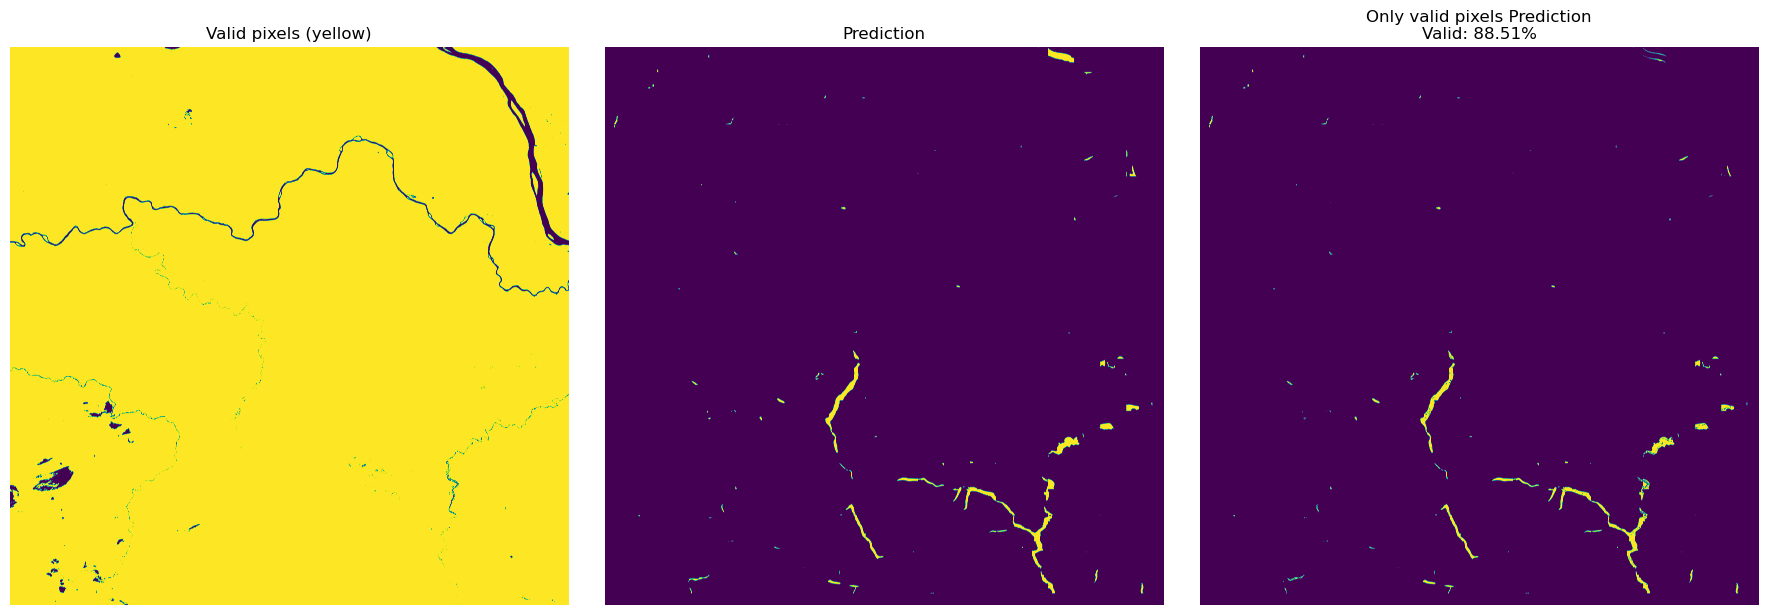

In [25]:
# Calculate metrics
positives_before = np.sum(pred == 1)
positives_after = np.sum(valid_pred == 1)
valid_percentage = positives_after / positives_before * 100
print(f"Percentage of valid prediction pixels: {valid_percentage:.2f}%")

# Visualize the two .tif files
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot the first .tif file
ax1.imshow(scl, cmap='viridis')
ax1.set_title("Valid pixels (yellow)")
ax1.axis('off')

# Plot the second .tif file
ax2.imshow(pred, cmap='viridis')
ax2.set_title("Prediction")
ax2.axis('off')

# Plot the third .tif file with the metric in the title
ax3.imshow(valid_pred, cmap='viridis')
ax3.set_title(f"Only valid pixels Prediction\nValid: {valid_percentage:.2f}%")
ax3.axis('off')

# Show the plots
plt.tight_layout()
plt.show()

In [26]:
# # load the original image 
# original_img = 'data/validation-download/' + str(tile_id) + '.tif'
# with rasterio.open(original_img) as src:
#     # read first 3 bands 
#     pixels = src.read([1, 2, 3])  # Read the first three bands

# # normalize and clip the image ranges
# pixels = (pixels - pixels.min()) / (pixels.max() - pixels.min())
# pixels = np.clip(pixels, 0, 1)

# # downsample the image to 512x512
# pixels = pixels[:, ::4, ::4]  # Downsample by a factor of 4

# # show image
# plt.imshow(pixels.transpose(1, 2, 0))

In [27]:
import rasterio
from rasterio import features
import geopandas as gpd
from shapely.geometry import shape

# Open the stack geotiff file to get the georeference information
with rasterio.open(file_path_scl) as src:
    profile = src.profile

# Update the profile to match the new data
profile.update(
    dtype=rasterio.uint8,
    count=1,
    compress='lzw'
)

# Save the big_pred numpy array as a geotiff file
output_file = 'data/validation-download/' + str(tile_id) + '_pred_validated.tif'
with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write(valid_pred, 1)

# Convert the numpy array to a raster shapefile
shapes = features.shapes(valid_pred.astype(rasterio.uint8), transform=profile["transform"])
geoms = [shape(geom) for geom, value in shapes if value == 1]
gdf = gpd.GeoDataFrame(geometry=geoms)

# Save the GeoDataFrame as a geopackage
output_file = 'data/validation-download/' + str(tile_id) + '_pred_validated.gpkg'
gdf.to_file(output_file, driver='GPKG')